In [ ]:
!pip install matplotlib
!pip install tensorflow==1.14
!pip install sklearn
!pip install keras==2.4.3

In [1]:
from pyspark.sql import SparkSession

Chúng ta cần khai báo địa chỉ spark trong môi trường docker: "spark://spark-master:7077"
*Sau khi kết nối được với spark thông qua spark context, mở trang localhost:8080 sẽ thấy một job đang chạy*  

In [3]:
packages = ["org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.1",
            "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1"]
packages = ",".join(packages)

master = "spark://spark-master:7077"
appName = "Visualize"

spark = SparkSession.builder \
                    .master(master) \
                    .appName(appName) \
                    .config("spark.jars.packages", packages) \
                    .config("spark.executor.memory", "1024m") \
                    .config("spark.executor.core", "1") \
                    .getOrCreate()

spark

Chạy chương trình logger trong scripts/run-logger.sh để thực hiện streaming dữ liệu.
Dùng spark để nhận dữ liệu được streaming từ kafka tại df

In [4]:
df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "kafka:9093, kafka1:9093") \
  .option("subscribe", "USDEUR") \
  .option("startingOffsets", "earliest") \
  .load()

In [6]:
from pyspark.sql.functions import col, udf, split, mean
from pyspark.sql import Row, DataFrame
import numpy as np

Trích xuất các thông tin cần thiết từ dữ liệu và ghi vào bộ nhớ ram ở dạng temporary table

In [7]:
value = df.select(col("value").cast("string").alias("Value"))
# value.writeStream.format("memory").queryName("value").outputMode("update").start()

split_col = split(col("Value"), ",")
extract_task = value.select(split_col.getItem(0).cast("int").alias('id'),
                            split_col.getItem(1).cast("string").alias("Time"),
                            split_col.getItem(2).cast("float").alias("Open"),
                            split_col.getItem(3).cast("float").alias("High"),
                            split_col.getItem(4).cast("float").alias("Low"),
                            split_col.getItem(5).cast("float").alias("Close"),
                            split_col.getItem(6).cast("float").alias("Volume"))
                            
query = extract_task.writeStream \
                     .format("memory") \
                     .queryName("total") \
                     .outputMode("update") \
                     .start()

In [17]:
spark.sql("show tables").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |    total|       true|
+--------+---------+-----------+



Query quan sát dữ liệu với 20 rows đầu tiên


In [12]:
data = spark.sql("select * from total")
print(len(np.array(data.collect())))
data.show()

2457
+---+----------------+-------+-------+-------+-------+------+
| id|            Time|   Open|   High|    Low|  Close|Volume|
+---+----------------+-------+-------+-------+-------+------+
|  0|2020-10-27 04:03| 1.1821|1.18215|1.18208|1.18209| 419.0|
|  1|2020-10-27 04:04|1.18208|1.18214|1.18208|1.18214| 145.0|
|  2|2020-10-27 04:05|1.18214|1.18216|1.18212|1.18214| 176.0|
|  3|2020-10-27 04:07|1.18214|1.18225|1.18214|1.18224| 119.0|
|  4|2020-10-27 04:08|1.18223|1.18225|1.18221|1.18222| 255.0|
|  5|2020-10-27 04:09|1.18223|1.18226|1.18221|1.18224| 219.0|
|  6|2020-10-27 04:10|1.18225|1.18226|1.18224|1.18225| 156.0|
|  7|2020-10-27 04:11|1.18224|1.18225|1.18224|1.18224| 102.0|
|  8|2020-10-27 04:12|1.18225|1.18235|1.18221|1.18234| 641.0|
|  9|2020-10-27 04:13|1.18234|1.18235|1.18226|1.18229| 450.0|
| 10|2020-10-27 04:14|1.18228|1.18231|1.18227|1.18229| 582.0|
| 11|2020-10-27 04:15|1.18231|1.18231|1.18228|1.18229| 306.0|
| 12|2020-10-27 04:16| 1.1823|1.18233|1.18228|1.18233| 379.0|
| 1

Sử dụng matplotlib để visualize dữ liệu dạng streaming, những dữ liệu mới sẽ được tự động visualize lên.

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(20,10), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

data1 = collections.defaultdict(list)
v = list(np.array(data.select("Close").collect())[:,0])
data1['foo'] = v
# data1['fa'] = list(np.array(data.select("Close").collect())[:,0] + 0.01)
while(1):
    if(v[-1] != np.array(data.select("Close").collect())[-1][0]) :
        v.append(np.array(data.select("Close").collect())[-1][0])
        data1['foo'].append(np.array(data.select("Close").collect())[-1][0])
#         data1['fa'].append(np.array(data.select("Close").collect())[-1][0] + 0.01)
        live_plot(data1)

### Build model LSTM

In [19]:
# data = spark.sql("select * from total")
dataset = np.array(data.select("Close").collect())
dataset.shape

(2423, 1)

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
#Training and test sets
train = dataset[:1500]
test = dataset[1500:]

print(train.shape)
print(test.shape)

(1500, 1)
(923, 1)


In [21]:
def get_data(data, look_back):
    datax, datay = [],[]
    for i in range(len(data)-look_back-1):
        datax.append(data[i:(i+look_back),0])
        datay.append(data[i+look_back,0])
    return np.array(datax) , np.array(datay)
look_back = 1

x_train , y_train = get_data(train, look_back)
print(x_train.shape)
print(y_train.shape)


(1498, 1)
(1498,)


In [22]:
x_test , y_test = get_data(test,look_back)
print(x_test.shape)
print(y_test.shape)

(921, 1)
(921,)


In [23]:
#Processing train and test sets for LSTM model
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)

(1498, 1, 1)
(921, 1, 1)


In [25]:
#Defining the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

n_features=x_train.shape[1]
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(1,1)))
model.add(Dense(n_features))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Compiling
model.compile(optimizer='adam', loss = 'mse')

#Training
model.fit(x_train,y_train, epochs = 5, batch_size=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
1498/1498 [==============================] - 6s 4ms/sample - loss: 0.0292
Epoch 2/5
1498/1498 [==============================] - 4s 3ms/sample - loss: 6.0421e-04
Epoch 3/5
1498/1498 [==============================] - 4s 3ms/sample - loss: 1.6015e-04
Epoch 4/5
1498/1498 [==============================] - 4s 3ms/sample - loss: 1.4155e-04
Epoch 5/5
1498/1498 [==============================] - 4s 3ms/sample - loss: 1.4672e-04


In [27]:
#Prediction using the trained model
scaler.scale_

array([84.24580961])

In [28]:
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred[:10])


[[1.1788462]
 [1.1787559]
 [1.1784614]
 [1.1784179]
 [1.1784527]
 [1.1784179]
 [1.1782707]
 [1.1782191]
 [1.1782105]
 [1.1782191]]


In [29]:
#Processing test shape
y_test = np.array(y_test).reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
print(y_test[:10])

[[1.17861998]
 [1.17829001]
 [1.17823994]
 [1.17828   ]
 [1.17823994]
 [1.17806995]
 [1.17800999]
 [1.17799997]
 [1.17800999]
 [1.17786002]]


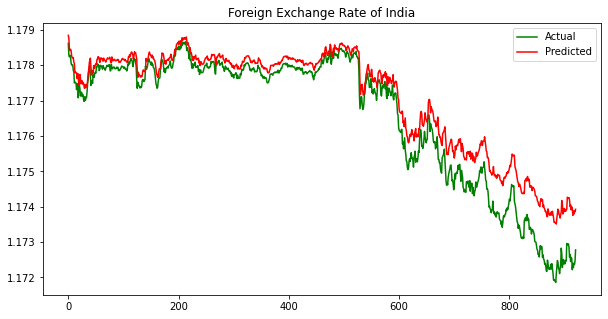

In [30]:
#Visualizing the results
plt.figure(figsize=(10,5))
plt.title('Foreign Exchange Rate of India')
plt.plot(y_test , label = 'Actual', color = 'g')
plt.plot(y_pred , label = 'Predicted', color = 'r')
plt.legend()